<a href="https://colab.research.google.com/github/cappelchi/Ancient-DNA-with-TPU/blob/master/Deep_Learning_on_Ancient_DNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Learning on Ancient DNA

Author [Nikolay Oskolkov](https://towardsdatascience.com/@nikolay.oskolkov)

Углубляюсь в тему повторяя код и адапртиру его под  TPU. Оригинал статьи читайте [здесь](https://towardsdatascience.com/deep-learning-on-ancient-dna-df042dc3c73d)

![alt text](https://cdn-images-1.medium.com/max/800/1*ybMR7E_I8f1ruQfKFO_tcA.jpeg)

In [0]:
!pip install pysam

In [0]:
import os
import numpy as np
import pysam
from google.colab import files
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import time
from sklearn.model_selection import train_test_split
import datetime

In [0]:

!wget 'ftp://ftp.ebi.ac.uk/pub/databases/ensembl/neandertal/BAM_files/Neandertal.bam'
!wget 'ftp://ftp.ebi.ac.uk/pub/databases/ensembl/neandertal/BAM_files/Neandertal.bam.bai'
!wget 'ftp://ftp.ebi.ac.uk/pub/databases/ensembl/neandertal/BAM_files/French.bam'
!wget 'ftp://ftp.ebi.ac.uk/pub/databases/ensembl/neandertal/BAM_files/French.bam.bai'


--2019-05-12 15:26:11--  ftp://ftp.ebi.ac.uk/pub/databases/ensembl/neandertal/BAM_files/Neandertal.bam
           => ‘Neandertal.bam’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.192.4
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.192.4|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/ensembl/neandertal/BAM_files ... done.
==> SIZE Neandertal.bam ... 4145696756
==> PASV ... done.    ==> RETR Neandertal.bam ... done.
Length: 4145696756 (3.9G) (unauthoritative)

Neandertal.bam      100%[===================>]   3.86G  24.4MB/s    in 2m 46s  

2019-05-12 15:28:57 (23.9 MB/s) - ‘Neandertal.bam’ saved [4145696756]

--2019-05-12 15:28:59--  ftp://ftp.ebi.ac.uk/pub/databases/ensembl/neandertal/BAM_files/Neandertal.bam.bai
           => ‘Neandertal.bam.bai’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.192.4
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.192.4|:21... connected.
Log

In [0]:
neand = pysam.AlignmentFile('Neandertal.bam', 'rb')

In [0]:
iter = neand.fetch('chr1', 0, 249000000)

In [0]:
neand_lengths =[]

In [0]:
for i in iter:
    neand_lengths.append(i.infer_query_length())

<function matplotlib.pyplot.show>

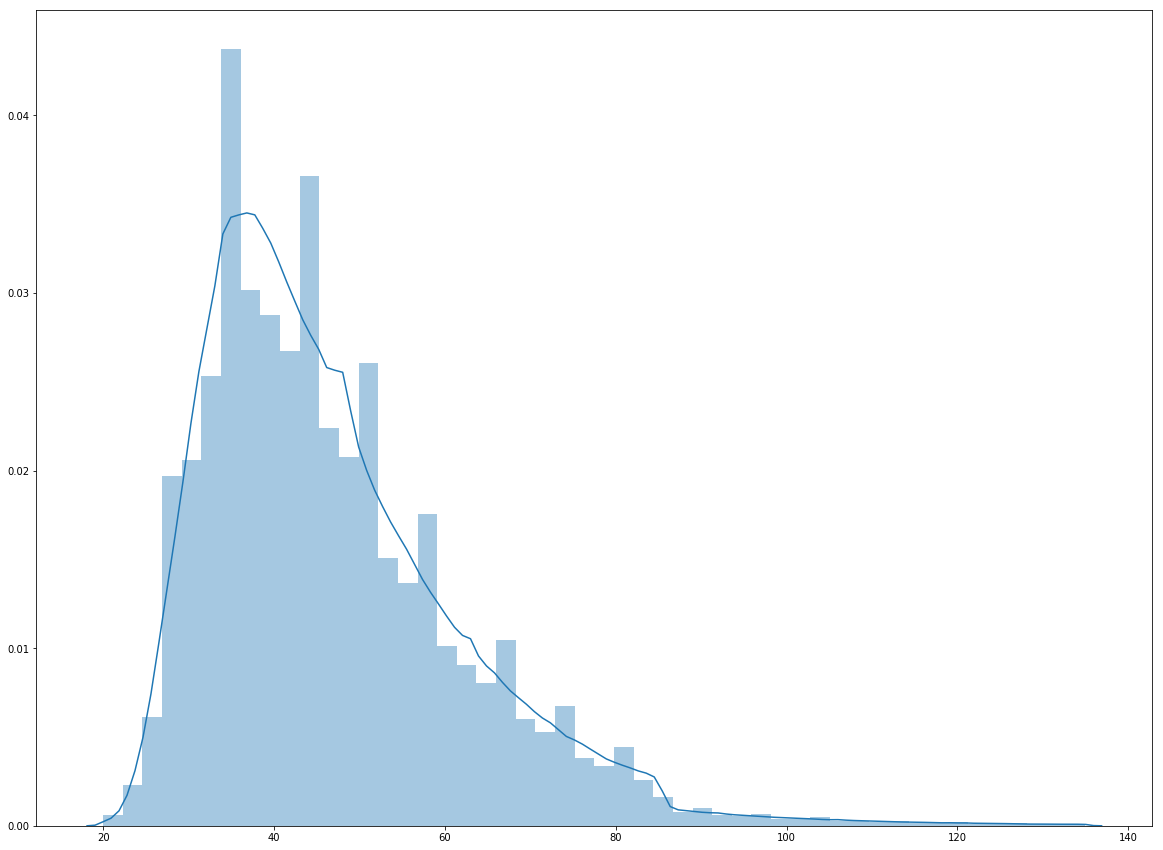

In [0]:
plt.figure(figsize=(20,15))
sns.distplot(neand_lengths)
plt.show

In [0]:
# Extract 76 nt ancient DNA sequances
neand_seqs = []
for j in tqdm(range(1, 11)):
    iter = neand.fetch('chr' + str(j))
    for i in iter:
        if i.infer_query_length() == 76:
            s = str(i.get_forward_sequence())
            if s.count('A') > 0 and s.count('C') > 0 and s.count('G') > 0 and s.count('T') > 0 and 'N' not in s:
                neand_seqs.append(i.get_forward_sequence())

# Read modern DNA sample
modern = pysam.AlignmentFile('French.bam', 'rb')
modern_seqs = []
for j in tqdm(range (1, 11)):
    iter = modern.fetch('chr' + str(j))
    for i in iter:
        if len(modern_seqs) == len(neand_seqs):
            break
        else:
            s = str(i.get_forward_sequence())
            if s.count('A') > 0 and s.count('C') > 0 and s.count('G') > 0 and s.count('T') > 0 and 'N' not in s:
                modern_seqs.append(i.get_forward_sequence())
sequences = neand_seqs + modern_seqs
labels = list(np.ones(len(neand_seqs))) + list(np.zeros(len(modern_seqs)))

100%|██████████| 10/10 [00:01<00:00,  1.30s/it]


In [0]:
# One-hot encode Sequences
integer_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(categories= 'auto')
input_features = []

In [0]:
for sequence in tqdm(sequences):
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

100%|██████████| 530480/530480 [04:51<00:00, 1822.86it/s]


In [0]:
np.shape(input_features)

(530480, 76, 4)

In [0]:
np.set_printoptions(threshold = 40)
input_features = np.stack(input_features)
print('Example sequence\n-----------------------')
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 AAATCATCAG ... CTCCAAAACT
One hot encoding of Sequence #1:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [0]:
# One-hot encode Labels
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()
print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[1. 1. 1. ... 0. 0. 0.]]
One-hot encoded labels:
 [[0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


In [0]:
#input_labels = np.expand_dims(input_labels, axis = 1) # run if ses2sec Wavenet

In [0]:
#input_features = np.expand_dims(input_features, axis = -1) # run if 2DConv

In [0]:
input_features = input_features.astype(np.float32)
input_labels = input_labels.astype(np.float32)

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels,
    test_size = 0.25, random_state = 42
    )

In [0]:
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
import tensorflow.keras.backend as K
#from keras.applications import DenseNet121 as DenseNet

print (tf.__version__)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


In [0]:
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU at: {}'.format(TPU_ADDRESS))
    #tpu = tf.contrib.cluster_resolver.TPUClusterResolver() # Picks up a connected TPU on Google's Colab, ML Engine, Kubernetes 
    #USE_TPU = True
except KeyError:
    print('TPU not found')

Found TPU at: grpc://10.73.166.162:8470


In [0]:
nt_length = 76
batch_size = 1024
dilation_rates = [2**i for i in range(8)] 
filter_width = 2
n_filters = 32 

In [0]:
def train_input_fn(batch_size=batch_size):
    # Convert the inputs to a Dataset.                                        
    dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))     
    
    # Shuffle, repeat, and batch the examples.    
    #dataset = dataset.cache() # Loads the data into memory since its such a small dataset
    #dataset = dataset.shuffle(388, reshuffle_each_iteration = False)
    dataset = dataset.repeat() 
    dataset = dataset.batch(batch_size, drop_remainder=True)

    # Return the dataset.
    return dataset
train_input_fn()

<DatasetV1Adapter shapes: ((1024, 76, 4), (1024, 2)), types: (tf.float32, tf.float32)>

In [0]:
def test_input_fn(batch_size=batch_size):
    # Convert the inputs to a Dataset.        
    dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
    
    # Shuffle, repeat, and batch the examples.
    #dataset = dataset.cache()
    #dataset = dataset.shuffle(129, reshuffle_each_iteration = False)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)

    # Return the dataset.
    return dataset
test_input_fn()

<DatasetV1Adapter shapes: ((1024, 76, 4), (1024, 2)), types: (tf.float32, tf.float32)>

In [0]:

input_shape = (nt_length, 4)
input_window = tf.keras.Input(
        name = 'input', shape = input_shape, batch_size = batch_size, dtype = tf.float32)
input = input_window
x = Conv1D(filters =32, kernel_size = 15, padding = 'same', 
                 kernel_initializer = 'he_uniform', 
                 #input_shape = input_shape, 
                 activation = 'selu',
                 kernel_regularizer=l2(0.001))(input)

#merge = concatenate([x, input])
x = Conv1D(filters = 32, kernel_size = 9, padding = 'same', 
                 kernel_initializer = 'he_uniform', 
                 activation = 'selu',
                 kernel_regularizer=l2(0.001))(x)


#merge = concatenate([x, input])
x = MaxPooling1D(pool_size =9)(x)

x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(16, kernel_initializer = 'he_uniform', activation = 'sigmoid',
         kernel_regularizer = l2(0.001))(x)
x = Dense(8, kernel_initializer = 'he_uniform', activation = 'sigmoid',
         kernel_regularizer = l2(0.001))(x)
x = Dropout(.2)(x)
output = Dense(2, activation = 'softmax')(x)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = tf.keras.Model(inputs = [input_window], outputs = [output])

In [0]:
#model.summary()

In [0]:
epochs = 200
learning_rate = 0.00005
momentum = 0.9
decay = learning_rate / epochs

In [0]:
#opt = tf.keras.optimizers.SGD(learning_rate, momentum, decay = decay, nesterov = False)
opt = tf.train.AdamOptimizer(learning_rate)

In [0]:
model.compile(
                   optimizer = opt,                  
                   loss = 'binary_crossentropy',                 
                   metrics = ['binary_accuracy']
                    )


In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,
                                             strategy = tf.contrib.tpu.TPUDistributionStrategy(
                                             tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.73.166.162:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 8320346695713909548)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8602227158873194455)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7667489625938668992)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1

In [0]:

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2019-05-12 15:48:17--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.173.3.255, 52.73.9.93, 52.200.123.104, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.173.3.255|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16529980 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  15.76M  41.1MB/s    in 0.4s    

2019-05-12 15:48:18 (41.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [16529980/16529980]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:

LOG_DIR = './log'  
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


https://53038343.ngrok.io


In [0]:
NAME = f'Ancient_DNA {time.strftime("%Y-%m-%d-%H.%M.%S", time.localtime())}'
log_dir = f'./log/{NAME}'
tensorboard = TensorBoard(log_dir = log_dir)
checkpointer = ModelCheckpoint(filepath='./Ancient_DNA_1.h5',monitor='val_acc', verbose=0, 
                               save_best_only=True, save_weights_only = True) # save best model
start_training = datetime.datetime.now()
history = tpu_model.fit(train_input_fn,                                                 
                         steps_per_epoch = 388,
                         epochs = 50,
                         #shuffle = True,
                         validation_data = test_input_fn,                        
                         validation_steps = 129,
                         callbacks = [
                                      #tensorboard,                                      
                                      #checkpointer
                                     ]
                                   )
print('Training time = ', datetime.datetime.now() - start_training)

Epoch 1/50
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 76, 4), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 2), dtype=tf.float32, name=None)]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 3.0541727542877197 secs
INFO:tensorflow:Setting weights on TPU model.
386/388 [============================>.] - ETA: 0s - loss: 0.8514 - binary_accuracy: 0.5455INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 76, 4), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 2), dtype=tf.float32, name=None)]
INFO:tensorflow:Overriding default placeholder.
I

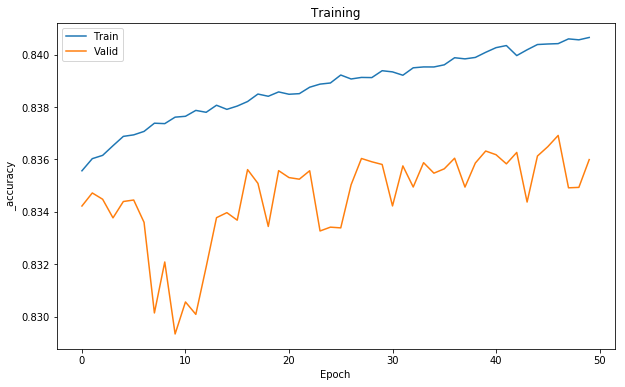

In [0]:
plt.figure(figsize=(10,6))  
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('_accuracy')
plt.title('Training')
plt.legend(['Train','Valid'])

In [0]:
def save_all(weights_tpu = 'weights_tpu.h5', weights_cpu = 'weights_cpu.h5', model_wpath = 'Ancient_DNA.json'):
    
    tpu_model.save_weights(weights_tpu, overwrite = True)
    cpu_saved_model = tpu_model.sync_to_cpu()
    cpu_saved_model.save_weights(weights_cpu, overwrite = True)
    saved_model = model.to_json()
    with open(model_wpath, 'w') as json_file:
        json_file.write(saved_model)

In [0]:
save_all()

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:Copying TPU weights to the CPU


In [0]:
def load_all (weights_file, model_wpath): 
    jfile = open(model_wpath, 'r')
    saved_model = jfile.read()
    jfile.close()
    loaded_model = model_from_json(saved_model)          
    loaded_model.load_weights(weights_file)
    
    return loaded_model

In [0]:
def predict_tpu (x, batch_size = batch_size):
    for i in tqdm(range(0, int(x.shape[0] / batch_size))):    
    
        if not(i):
            predict = np.array(tpu_model.predict(x[i * batch_size:(i + 1) * batch_size,:,:]))
        else:
            predict = np.append(predict,tpu_model.predict(x[i * batch_size:(i + 1) * batch_size,:,:]), axis =0)
        

    predict = np.append(predict,tpu_model.predict(x[-1024:,:,:])[- x.shape[0] % batch_size,:], axis = 0)
    return predict

In [0]:
#tpu_model.load_weights('?.h5')

In [0]:
def predict_cpu (x, cpu_model, batch_size = batch_size):
    for i in tqdm(range(0, int(x.shape[0] / batch_size))):    
    
        if not(i):
            predict = np.array(cpu_model.predict(x[i * batch_size:(i + 1) * batch_size,:,:]))
        else:
            predict = np.append(predict, cpu_model.predict(x[i * batch_size:(i + 1) * batch_size,:,:]), axis =0)
        
    print(np.shape(predict))
    predict = np.append(predict, cpu_model.predict(x[-1024:,:,:])[- x.shape[0] % batch_size:, -1,:], axis = 0)
    return predict

In [0]:
predict_DNA = predict_tpu(test_features)

100%|██████████| 129/129 [00:02<00:00, 50.17it/s]


ValueError: ignored

In [0]:
predict_DNA_argmax = np.argmax(predict_DNA, axis = 1)

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

In [0]:
print(test_features.shape, test_labels.shape)

(132620, 76, 4) (132620, 2)


In [0]:
plt.figure(figsize = (10,8))
cm = confusion_matrix(test_labels, predict_DNA_argmax)
print('Confusion matrix:\n', cm)

ValueError: ignored

<Figure size 720x576 with 0 Axes>